In [1]:
%load_ext autoreload

In [374]:
%autoreload

import jax
import jax.numpy as jnp
import jax.random as random
from jax.experimental.ode import odeint
from jax.experimental import stax
from jax.experimental import optimizers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jx.utils import next_key

In [109]:
k = 1.

def force(y, t):
    return [y[1], -k * y[0] + 0.1 * jnp.sin(y[0])]

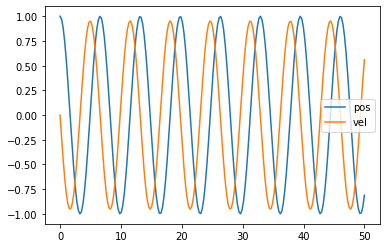

In [329]:
t = jnp.linspace(0., 50., 200)
sol = odeint(force, [1., 0.], t)
plt.plot(t, sol[0], label='pos')
plt.plot(t, sol[1], label='vel')
plt.legend()

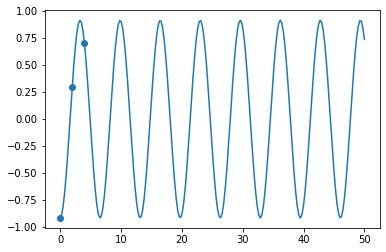

In [334]:
position_plot = sol[0]
force_plot = force(sol, t)[1]

t_data = jnp.arange(0., 5., 2)
dataset = odeint(force, [1., 0.], t_data)
position_data = dataset[0]
force_data = force(dataset, t_data)[1]

plt.plot(t, force_plot)
plt.scatter(t_data, force_data)

In [335]:
initfun, applyfun = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

inshape = (-1, 1,)
outshape, params = initfun(next_key(), inshape)

In [390]:
def loss(params, batch, rng, alpha=0.1):
    rand_positions = random.uniform(rng, shape=(100,1), minval=-1., maxval=1.)
    rand_pred = applyfun(params, rand_positions)
    pinnloss = jnp.sum(jnp.square(rand_pred - (-k * rand_positions)))
    
    inputs, labels = batch
    pred = applyfun(params, inputs)
    mseloss = jnp.sum(jnp.square(pred - labels))
    
    return mseloss + alpha * pinnloss 

In [391]:
optim_init, optim_update, get_params = optimizers.adam(1e-3)

In [393]:
@jax.jit
def step(i, opt_state, batch, rng):
    p = get_params(opt_state)
    rng, nk = random.split(rng)
    g = jax.grad(loss)(p, batch, nk, alpha=0.1)
    return optim_update(i, g, opt_state), rng

In [394]:
optim_state = optim_init(params)
features_labels = [position_data.reshape(-1, 1), force_data.reshape(-1, 1)]
rng = random.PRNGKey(0)

for i in (pbar := tqdm(range(5000))):
    optim_state, rng = step(i, optim_state, features_labels, rng)
    if i % 500 == 0:
        net_params = get_params(optim_state)
        pbar.set_description(f"loss: {loss(net_params, features_labels, rng):.2e}")

loss: 8.11e-03: 100%|██████████████████████| 5000/5000 [00:00<00:00, 5457.00it/s]


In [395]:
learned_force = applyfun(net_params, position_plot.reshape(-1, 1))

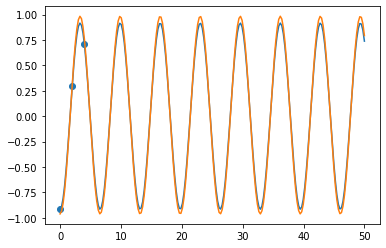

In [396]:
plt.plot(t, force_plot)
plt.plot(t, learned_force)
plt.scatter(t_data, force_data)